In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else: 
  policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Laptop GPU, compute capability 8.6


In [3]:
train_dir = "data/train"
test_dir = "data/test"

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=(224,224),
                                                                shuffle=True
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=(224,224),
                                                                shuffle=False
)

Found 24000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.


In [6]:
class_names = train_data.class_names
class_names

['aloevera',
 'banana',
 'bilimbi',
 'cantaloupe',
 'cassava',
 'coconut',
 'corn',
 'cucumber',
 'curcuma',
 'eggplant',
 'galangal',
 'ginger',
 'guava',
 'kale',
 'longbeans',
 'mango',
 'melon',
 'orange',
 'paddy',
 'papaya',
 'peper chili',
 'pineapple',
 'pomelo',
 'shallot',
 'soybeans',
 'spinach',
 'sweet potatoes',
 'tobacco',
 'waterapple',
 'watermelon']

In [7]:
def view_random_image(target_dir, target_class):
    directory = os.path.join(target_dir, target_class)
    random_img = random.sample(os.listdir(directory), 1)

    img = mpimg.imread(os.path.join(directory, random_img[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    return img

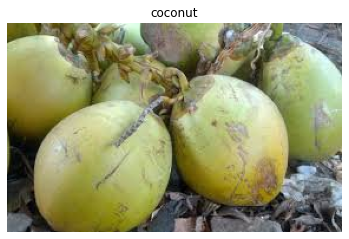

In [10]:
img = view_random_image(train_dir, random.choice(os.listdir(train_dir)))

In [11]:
checkpoint_path = "checkpoints/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_accuracy",
    save_freq="epoch",
    verbose=1
)

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1
)

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    #tf.keras.layers.Rescaling(1/255.)
])

In [25]:
#model
base_model = tf.keras.applications.EfficientNetV2M(include_top=False)
base_model.trainable=False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
#x = data_augmentation(inputs)
#x = base_model(x, training=False)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = tf.keras.layers.Dense(30)(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

214201816/214201816 [==============================] - 25s 0us/step


In [26]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, None, None, 1280)  53150388 
 l)                                                              
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense_2 (Dense)             (None, 30)                38430     
                                                                 
 softmax_float32 (Activation  (None, 30)               0         
 )                                                               
                                                           

In [27]:
history_0 = model_0.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[checkpoint_callback]
)

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.6817
Epoch 1: val_accuracy did not improve from 0.83594
750/750 [==============================] - 95s 111ms/step - loss: 1.2066 - accuracy: 0.6817 - val_loss: 0.7472 - val_accuracy: 0.7199
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.7864
Epoch 2: val_accuracy did not improve from 0.83594
750/750 [==============================] - 82s 109ms/step - loss: 0.7374 - accuracy: 0.7864 - val_loss: 0.6659 - val_accuracy: 0.7210
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.8100
Epoch 3: val_accuracy did not improve from 0.83594
750/750 [==============================] - 81s 108ms/step - loss: 0.6358 - accuracy: 0.8100 - val_loss: 0.5627 - val_accuracy: 0.7980
Epoch 4/10
750/750 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.8242
Epoch 4: val_accuracy did not improve from 0.83594
750/750 [=

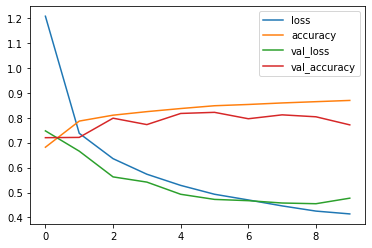

In [28]:
pd.DataFrame(history_0.history).plot();

In [29]:
model_0.evaluate(test_data)

188/188 [==============================] - 18s 97ms/step - loss: 0.4909 - accuracy: 0.8412


[0.4909049868583679, 0.8411666750907898]

In [31]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [32]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"]
)

In [33]:
history_new = model_0.fit(train_data,
                        epochs=20,
                        initial_epoch=history_0.epoch[-1],
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data))
)

Epoch 10/20
750/750 [==============================] - 97s 113ms/step - loss: 0.4026 - accuracy: 0.8665 - val_loss: 0.3911 - val_accuracy: 0.7746
Epoch 11/20
750/750 [==============================] - 83s 111ms/step - loss: 0.2862 - accuracy: 0.9018 - val_loss: 0.3620 - val_accuracy: 0.7801
Epoch 12/20
750/750 [==============================] - 84s 111ms/step - loss: 0.2257 - accuracy: 0.9173 - val_loss: 0.3377 - val_accuracy: 0.7969
Epoch 13/20
750/750 [==============================] - 83s 111ms/step - loss: 0.1832 - accuracy: 0.9285 - val_loss: 0.3109 - val_accuracy: 0.8002
Epoch 14/20
750/750 [==============================] - 83s 111ms/step - loss: 0.1604 - accuracy: 0.9359 - val_loss: 0.2987 - val_accuracy: 0.8002
Epoch 15/20
750/750 [==============================] - 83s 111ms/step - loss: 0.1426 - accuracy: 0.9428 - val_loss: 0.3049 - val_accuracy: 0.7980
Epoch 16/20
750/750 [==============================] - 83s 111ms/step - loss: 0.1305 - accuracy: 0.9448 - val_loss: 0.3018 -

In [34]:
model_0.evaluate(test_data)

188/188 [==============================] - 18s 95ms/step - loss: 0.2870 - accuracy: 0.8960


[0.28704601526260376, 0.8960000276565552]

In [35]:
model_0.save("saved_models/model_0.h5")

In [36]:
model = tf.keras.models.load_model("saved_models/model_0.h5")

In [37]:
results = model.evaluate(test_data)

188/188 [==============================] - 21s 98ms/step - loss: 0.2870 - accuracy: 0.8960


In [38]:
pred_probs = model.predict(test_data, verbose=1)

188/188 [==============================] - 21s 96ms/step


In [39]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
y_labels = [labels.numpy().argmax() for images,labels in test_data.unbatch()]
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
from sklearn.metrics import accuracy_score
sklearn_acc = accuracy_score(y_true=y_labels, 
                            y_pred=pred_classes
)

sklearn_acc

0.896

In [42]:
np.isclose(results[1], sklearn_acc)

True

In [43]:
class_names = test_data.class_names

In [44]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.RdPu) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

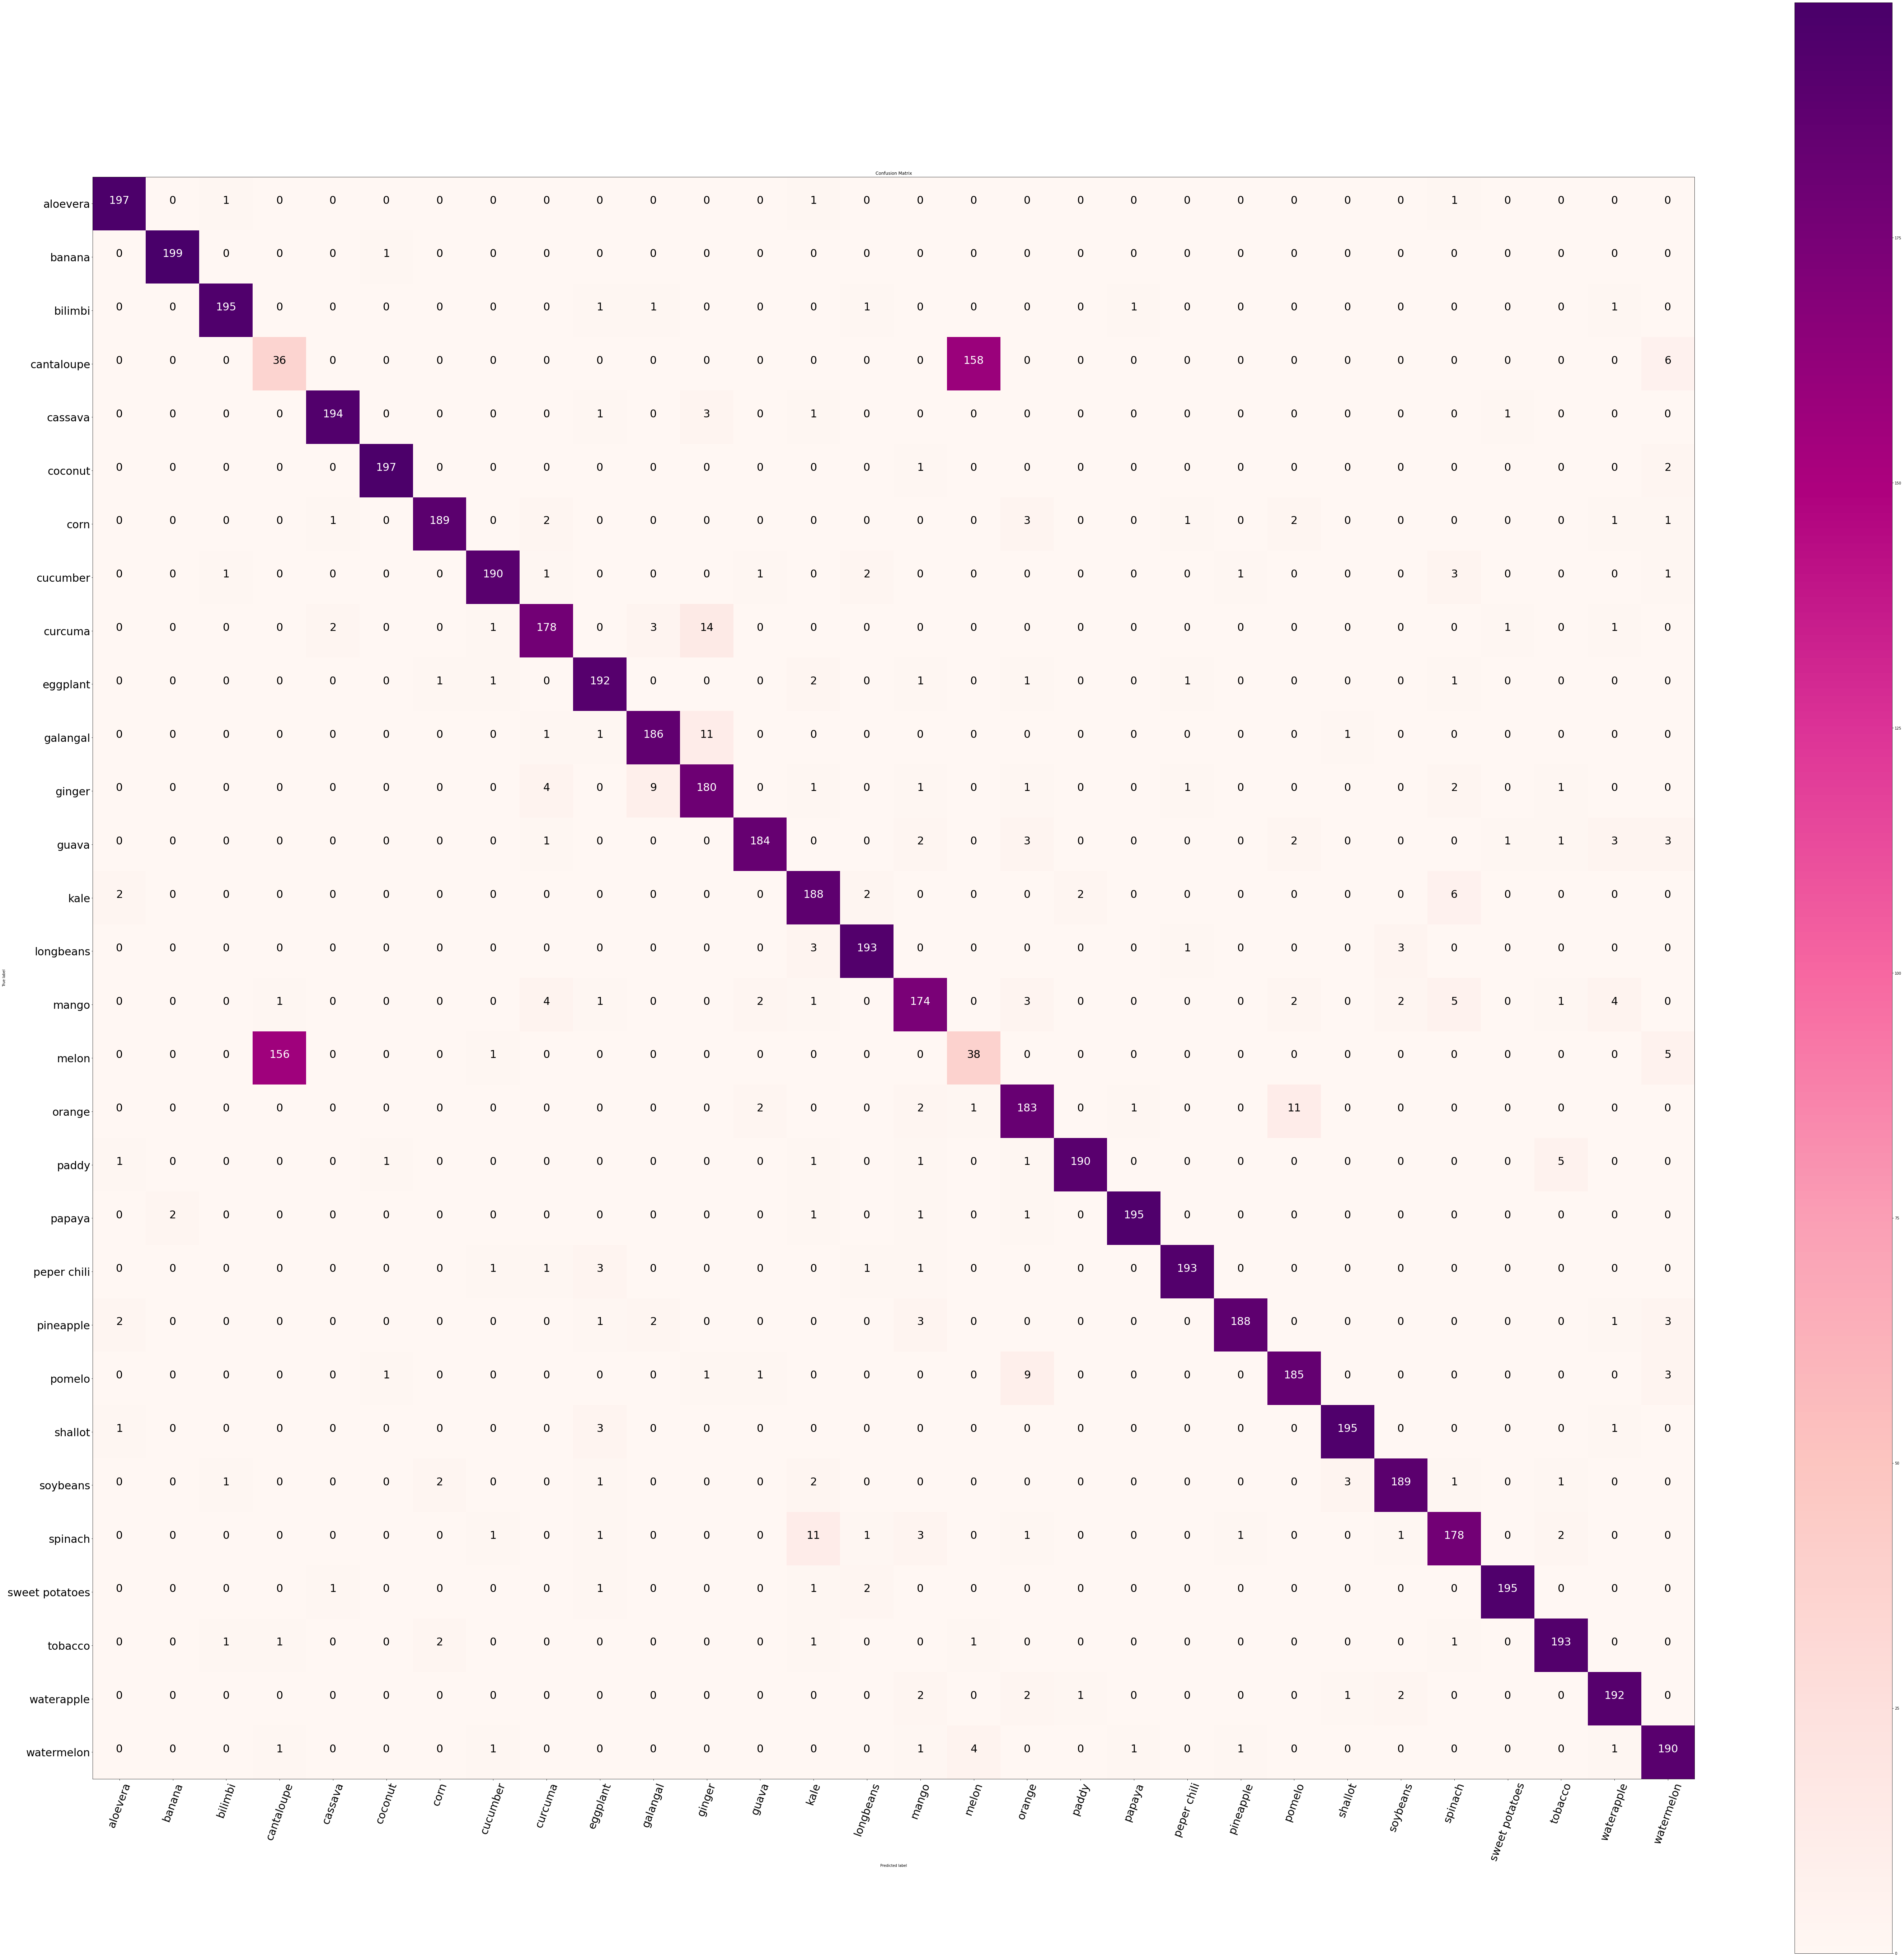

In [46]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_names, figsize=(100,100), text_size=30)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.99      0.99      0.99       200
           2       0.98      0.97      0.98       200
           3       0.18      0.18      0.18       200
           4       0.98      0.97      0.97       200
           5       0.98      0.98      0.98       200
           6       0.97      0.94      0.96       200
           7       0.97      0.95      0.96       200
           8       0.93      0.89      0.91       200
           9       0.93      0.96      0.95       200
          10       0.93      0.93      0.93       200
          11       0.86      0.90      0.88       200
          12       0.97      0.92      0.94       200
          13       0.88      0.94      0.91       200
          14       0.96      0.96      0.96       200
          15       0.90      0.87      0.89       200
          16       0.19      0.19      0.19       200
          17       0.88    

In [48]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 28ms/step


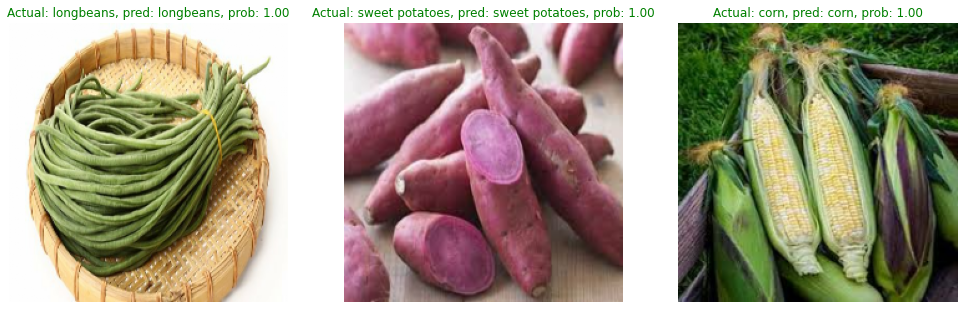

In [49]:
plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis("off");

In [50]:
class_names

['aloevera',
 'banana',
 'bilimbi',
 'cantaloupe',
 'cassava',
 'coconut',
 'corn',
 'cucumber',
 'curcuma',
 'eggplant',
 'galangal',
 'ginger',
 'guava',
 'kale',
 'longbeans',
 'mango',
 'melon',
 'orange',
 'paddy',
 'papaya',
 'peper chili',
 'pineapple',
 'pomelo',
 'shallot',
 'soybeans',
 'spinach',
 'sweet potatoes',
 'tobacco',
 'waterapple',
 'watermelon']

In [54]:
img_dir = "/home/felipeserver/Pictures/test_images/plants_types"

1/1 [==============================] - 0s 28ms/step


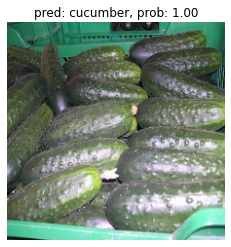

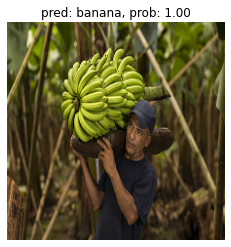

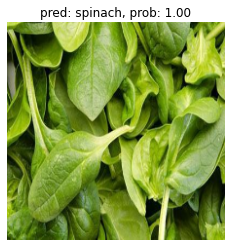

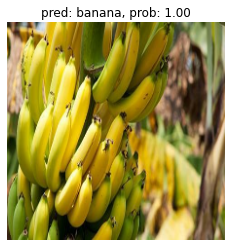

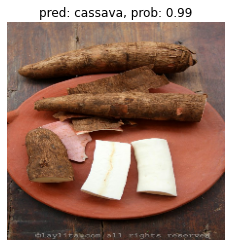

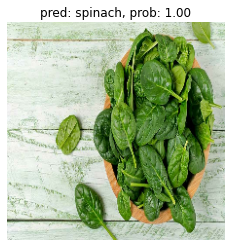

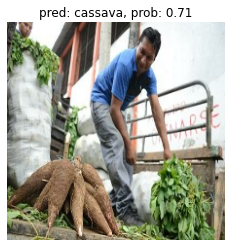

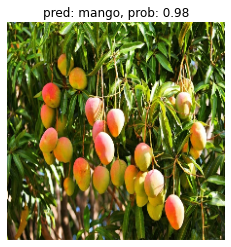

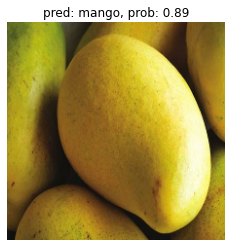

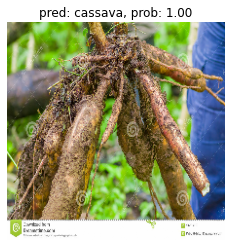

In [55]:
for image in os.listdir(img_dir):
    img = load_and_prep_image(os.path.join(img_dir,image), scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]

    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis('off');